In [1]:
import numpy
import scipy.sparse
from scipy.sparse.linalg import spsolve

import quadpy

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import meshio
import igl

import trimesh

from collections import namedtuple
from numba import jit

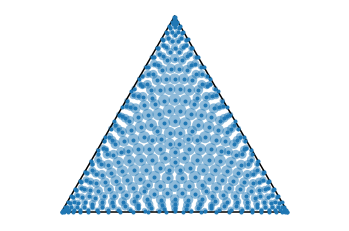

0.5

In [2]:
# some quadrature rule
scheme = quadpy.t2.get_good_scheme(48)
scheme.show()
scheme.integrate(lambda x: numpy.ones(x.shape[1]), [[0.0, 0.0], [1.0, 0.0], [0.0, 1.0]])

In [3]:
def point_triangle_coord(p, a, b, c):
    return igl.barycentric_coordinates_tri(
        p.reshape((1, -1)).copy(), a.reshape((1, -1)).copy(), 
        b.reshape((1, -1)).copy(), c.reshape((1, -1)).copy())

## Meshes

In [4]:
coarse_mesh = meshio.read("../meshes/sphere/sphere-coarse.msh")
V_coarse = coarse_mesh.points
F_coarse = coarse_mesh.cells[0].data.astype(int)
F_coarse = igl.boundary_facets(F_coarse)
V_coarse, F_coarse, *_ = igl.remove_unreferenced(V_coarse, F_coarse)

fine_mesh = meshio.read("../meshes/sphere/sphere-fine.obj")
V_fine = fine_mesh.points
F_fine = fine_mesh.cells[0].data.astype(int)
# E_fine = igl.boundary_facets(fine_mesh.cells[0].data.astype(int))
# V_fine, E_fine, *_ = igl.remove_unreferenced(V_fine, E_fine[:, [0, 1, 1]])

# point_triangle_coord(V_coarse[0], *V_fine[F_fine[10]])

In [5]:
U_coarse = numpy.zeros(V_coarse.shape)
U_coarse[:, 1] += numpy.cos(1 * numpy.pi * V_coarse[:, 0])

U_fine = numpy.zeros(V_fine.shape)
U_fine[:, 1] += numpy.cos(1 * numpy.pi * V_fine[:, 0])

In [6]:
coarse_coll = False
if coarse_coll:
    V_coll, V_fem = V_coarse, V_fine
    F_coll, F_fem = F_coarse, F_fine
    U_coll, U_fem = U_coarse, U_fine
else:
    V_coll, V_fem = V_fine, V_coarse
    F_coll, F_fem = F_fine, F_coarse
    U_coll, U_fem = U_fine, U_coarse

# V_fem = V_coll
# E_fem = E_coll
# U_fem = U_coll

## L2 Projection

In [7]:
def hat_phi0(x):
    return 1-x[0]-x[1]
def hat_phi1(x):
    return x[0]
def hat_phi2(x):
    return x[1]

In [24]:
Basis = namedtuple("Basis", ["n_bases", "phi", "loc_2_glob", "grad_gmapping"])

def build_bases(V, F):
    return [Basis(
        n_bases=3,
        phi=[hat_phi0, hat_phi1, hat_phi2], 
        loc_2_glob=f.tolist(),
        # gmapping =lambda x, f=f: (V[f[0]] * x[0] + V[f[1]] * x[1] + V[f[2]] * x[2]),
        grad_gmapping=numpy.linalg.norm(numpy.cross(V[f[1]] - V[f[0]], V[f[2]] - V[f[0]]))
    ) for f in F]

In [30]:
# @jit(nopython=True)
def compute_mass_mat(elements):
    rows, cols, vals = [], [], []
    
    q_pts = scheme.points.T
    q_w = scheme.weights

    # same as above but now we use phi instead of grad_phi and no division
    for el in elements:
        for i, phi_i in enumerate(el.phi):
            for j, phi_j in enumerate(el.phi):
                # ∫_{ŝ_j} ϕ̂ᵢ⋅ϕ̂ⱼ \,(s_{j, 1} - s_{j, 0})
                val = scheme.integrate(
                    lambda x: phi_i(x) * phi_j(x) * el.grad_gmapping,
                    [[0.0, 0.0], [1.0, 0.0], [0.0, 1.0]])

                rows.append(el.loc_2_glob[i])
                cols.append(el.loc_2_glob[j])
                vals.append(val)

    return scipy.sparse.coo_matrix((vals, (rows, cols))).tocsc()
    

In [26]:
def find_and_eval(pt, bases, V, F, prox_query):
    closest_point, distance, triangle_id = prox_query.on_surface(pt.reshape(1, 3))

    # find the closest element index
    index = triangle_id[0]
    # find the coords of the closest point in the closest element
    coords = point_triangle_coord(closest_point, *V[F[index]])
    
    el = bases[index]
    return [
        (el.loc_2_glob[j], el.phi[j](coords))
        for j in range(el.n_bases)
    ]

In [27]:
def compute_mass_mat_cross(a, b, Vb, Fb):
    rows, cols, vals = [], [], []
    
    q_pts = scheme.points.T
    q_w = scheme.weights
    
    # Build a mesh for fast closest point
    prox_query = trimesh.proximity.ProximityQuery(trimesh.Trimesh(Vb, Fb))
    
    for el in a:
        for i in range(el.n_bases):
            others = {}
            
            for t, w in zip(q_pts, q_w):
                bc = t[1] * numpy.array([1, 0]) + t[2] * numpy.array([0, 1])
                pt = el.gmapping(t)
                bb = find_and_eval(pt, b, Vb, Fb, prox_query)
                
                for j in bb:
                    if j[0] not in others:
                        others[j[0]] = 0
                    others[j[0]] += w*j[1]*el.phi[i](bc) * el.grad_gmapping(bc)
            
            for j in others:
                rows.append(el.loc_2_glob[i])
                cols.append(j)
                vals.append(others[j])

    return scipy.sparse.coo_matrix((vals, (rows, cols))).tocsc()

In [22]:
A = V_coll
F_A = F_coll
B = V_fem
F_B = F_fem

In [28]:
A_bases = build_bases(A, F_A)
B_bases = build_bases(B, F_B)

In [31]:
MM = compute_mass_mat(A_bases)
assert(MM.shape == (A.shape[0], A.shape[0]))

In [ ]:
M = compute_mass_mat_cross(A_bases, B_bases, B, F_B)
print(M.shape, (A.shape[0], B.shape[0]))

(2562, 232) (2562, 232)


In [ ]:
M.shape, MM.shape

((2562, 232), (2562, 2562))

### Solve System

In [ ]:
def density(A):
    return (A.nnz / numpy.product(A.shape)) * 100

def print_density(A):
    print(f"{density(A):.2f}%")

def eliminate_near_zeros(A, tol=1e-12):
    A.data[numpy.abs(A.data) < tol] = 0
    A.eliminate_zeros()

def unity_error(W, tol=1e-11):
    return numpy.max(abs(W.sum(axis=1) - 1))

In [ ]:
W = spsolve(MM, M)
eliminate_near_zeros(W)
print_density(W)
print(unity_error(W))

41.56%
6.334044400091443e-12


In [ ]:
MM_lumped = scipy.sparse.csc_matrix(MM.shape)
MM_lumped.setdiag(MM.sum(axis=1))
W_lumped = spsolve(MM_lumped, M)
eliminate_near_zeros(W_lumped)
# print_density(W_lumped)
# print(unity_error(W_lumped))
print(f"{numpy.linalg.norm((W - W_lumped).A)} {density(W_lumped):.2f}% {unity_error(W_lumped)}")

14.318769113432612 2.25% 4.440892098500626e-16


/home/zachary/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning:

Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.



In [ ]:
print("cg_tol: error, density")
for tol in numpy.geomspace(1e-6, 1e-3, 4):
    W_CG = numpy.hstack([
        scipy.sparse.linalg.cg(MM, M.A[:, i], tol=tol)[0].reshape(-1, 1)
        for i in range(M.shape[1])])
    W_CG = scipy.sparse.csc_matrix(W_CG)
    eliminate_near_zeros(W_CG)
    print(f"{tol}: {numpy.linalg.norm((W - W_CG).A)} {density(W_CG):.2f}%")
W_CG /= W_CG.sum(axis=1)
W_CG = scipy.sparse.csc_matrix(W_CG)
eliminate_near_zeros(W_CG)
print(f"{tol}: {numpy.linalg.norm((W - W_CG).A)} {density(W_CG):.2f}% {unity_error(W_CG)}")

cg_tol: error, density
1e-06: 5.262499095129542e-05 34.30%
1e-05: 0.0005051837987542021 26.38%
0.0001: 0.005047807554731882 18.96%
0.001: 0.04504035306695522 12.89%
0.001: 0.04932393893916438 12.89% 1.3322676295501878e-15


In [ ]:
print("drop_tol: error, density, unity error")
for drop_tol in numpy.geomspace(1e-4, 1e-2, 3):
    MM_LU = scipy.sparse.linalg.spilu(MM, drop_tol=drop_tol)
    W_spilu = numpy.hstack([
        MM_LU.solve(M.A[:, i]).reshape(-1, 1) for i in range(M.shape[1])])
    W_spilu = scipy.sparse.csc_matrix(W_spilu)
    eliminate_near_zeros(W_spilu)
    print(f"{drop_tol}: {numpy.linalg.norm((W - W_spilu).A)} {density(W_spilu):.2f}% {unity_error(W_CG)}")

drop_tol: error, density, unity error
0.0001: 0.004602809176737046 37.65% 1.3322676295501878e-15
0.001: 0.044107001394758864 33.62% 1.3322676295501878e-15
0.01: 0.3729880580925997 29.24% 1.3322676295501878e-15


In [ ]:
print_density(M)
print_density(MM)
print(W.shape, U_fem.shape, V_coll.shape)

2.25%
0.27%
(2562, 232) (232, 3) (2562, 3)


## Visualization

In [ ]:
def MeshTrace(V, F, mode="lines", name=""):
    segments_x = []
    segments_y = []
    segments_z = []
    for f in F:
        segments_x.extend(V[f, 0].tolist() + [None])
        segments_y.extend(V[f, 1].tolist() + [None])
        segments_z.extend(V[f, 2].tolist() + [None])
    return go.Scatter3d(x=segments_x, y=segments_y, z=segments_z, mode=mode, name=name)

In [ ]:
X_coll = V_coll + W @ U_fem
X_coll_lumped = V_coll + W_lumped @ U_fem
X_coll_CG = V_coll + W_CG @ U_fem
X_coll_spilu = V_coll + W_spilu @ U_fem
X_fem = V_fem + U_fem

# fig = make_subplots(rows=1, cols=2)

# fig.add_trace(MeshTrace(V_fem, F_fem, name="V_fem"), row=1, col=1)
# fig.add_trace(MeshTrace(V_coll, F_coll, name="V_coll"), row=1, col=1)
fig = go.Figure([MeshTrace(X_coll, F_coll), MeshTrace(X_fem, F_fem)])
# fig.add_trace(MeshTrace(X_fem, F_fem,  mode="lines", name="Deformed V_fem"), row=1, col=2)
# fig.add_trace(MeshTrace(X_coll, F_coll,  mode="lines", name="Deformed V_coll"), row=1, col=2)
# fig.add_trace(MeshTrace(X_coll_lumped, F_coll,  mode="lines", name="Deformed (lumped) V_coll"), row=1, col=2)
# fig.add_trace(MeshTrace(X_coll_CG, F_coll,  mode="lines", name="Deformed (CG) V_coll"), row=1, col=2)
# fig.add_trace(MeshTrace(X_coll_spilu, F_coll,  mode="lines", name="Deformed (ILU) V_coll"), row=1, col=2)

fig.update_layout(width=1500, height=750, title="Displace V_fem")
fig.update_yaxes(scaleanchor="x", scaleratio=1)

In [ ]:
X_coll = V_coll + U_coll
X_fem = V_fem + W.T @ U_coll
X_fem_lumped = V_fem + W_lumped.T @ U_coll

fig = make_subplots(rows=2, cols=2)

fig.add_trace(MeshTrace(V_coll, E_coll, name="V_coll"), row=1, col=1),
fig.add_trace(MeshTrace(V_fem, E_fem, name="V_fem"), row=1, col=2),
fig.add_trace(MeshTrace(X_coll, E_coll, name="Deformed V_coll"), row=2, col=1),
fig.add_trace(MeshTrace(X_fem, E_fem, name="Deformed V_fem"), row=2, col=2),
fig.add_trace(MeshTrace(X_fem_lumped, E_fem, name="Deformed (lumped) V_fem"), row=2, col=2),

fig.update_layout(width=800, height=800, title="Displace V_fem")

None

NameError: name 'E_coll' is not defined